# Pandas - spojování tabulek

Tato lekce se nese ve znamení mnohosti a propojování - naučíš se  pracovat s více tabulkami najednou. Při tom společně projdeme (ne poprvé a ne naposledy) čištění reálných datových sad.

In [1]:
# Importy jako obvykle
import pandas as pd

## Spojování tabulek

V lekci, kde jsme zpracovávali data o počasí, jsme ti ukázali, že je pomocí funkce `concat` možné slepit dohromady několik objektů `DataFrame` či `Series`, pokud mají "kompatibilní" index. Nyní se na problematiku podíváme trochu blíže a ukážeme si, jak spojovat tabulky na základě různých sloupců, a co dělat, když řádky z jedné tabulky nepasují přesně na tabulku druhou.

Obecně pro spojování `pandas` nabízí tři funkce / metody, z nichž každá má svoje typické využití (možnostmi se ovšem překrývají):

- [`concat`](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.concat.html) je univerzální funkce pro slepování dvou či více tabulek / sloupců - pod sebe, vedle sebe, s přihlédnutím k indexům i bez něj. 
- [`merge`](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.merge.html) je univerzální funkce pro spojování tabulek na základě vazby mezi indexy nebo sloupci.
- [`join`](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.join.html) (metoda) zjednodušuje práci, když chceš spojit dvě tabulky na základě indexu.

Detailní rozbor toho, co která umí, najdeš v [dokumentaci](https://pandas.pydata.org/pandas-docs/stable/user_guide/merging.html). My si je také postupně ukážeme.

### Jednoduché skládání

#### Pod sebou

To je asi ten nejjednodušší případ - máme dva objekty `Series` nebo dva kusy tabulky se stejnými sloupci a chceme je spojit pod sebou. Na to se používá funkce [`concat`](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.concat.html):

In [3]:
a = pd.Series(["jedna", "dvě", "tři"])
b = pd.Series(["čtyři", "pět", "šest"])

In [4]:
pd.concat([a, b])

0    jedna
1      dvě
2      tři
0    čtyři
1      pět
2     šest
dtype: object

💡 Vidíš, že se index opakuje? Vytvořili jsme dvě `Series`, u kterých jsme index neřešili. Jenže `pandas` na rozdíl od nás ano, a tak poslušně oba indexy spojil, i za cenu duplicitních hodnot. Za cenu použití dodatečného argumentu `ignore_index=True` se tomu lze vyhnout, což si ukážeme na příklady spojování dvou tabulek o stejných sloupcích:

In [5]:
pd.concat([a, a, a, a, a], ignore_index=True)

0     jedna
1       dvě
2       tři
3     jedna
4       dvě
5       tři
6     jedna
7       dvě
8       tři
9     jedna
10      dvě
11      tři
12    jedna
13      dvě
14      tři
dtype: object

#### Vedle sebe

Toto asi použijete zřídka, ale když chceme "lepit" doprava (třeba deset `Series`), stačí přidat nám dobře známý argument `axis`:

In [6]:
pd.concat([a, a, a, a, a], axis="columns")

,0,1,2,3,4
0,jedna,jedna,jedna,jedna,jedna
1,dvě,dvě,dvě,dvě,dvě
2,tři,tři,tři,tři,tři


**Příklad:** Jak co nejrychleji "nakreslit prázdnou šachovnici" (obě slova jsou v uvozovkách)?

In [7]:
sachy = pd.concat(
    [
        pd.concat(   
            [pd.DataFrame([["⬜", "⬛"], ["⬛", "⬜"]])] * 4,
            axis=1)
    ] * 4
)
sachy.index = list(range(8, 0, -1))
sachy.columns = list("ABCDEFGH")
sachy

,A,B,C,D,E,F,G,H
8,⬜,⬛,⬜,⬛,⬜,⬛,⬜,⬛
7,⬛,⬜,⬛,⬜,⬛,⬜,⬛,⬜
6,⬜,⬛,⬜,⬛,⬜,⬛,⬜,⬛
5,⬛,⬜,⬛,⬜,⬛,⬜,⬛,⬜
4,⬜,⬛,⬜,⬛,⬜,⬛,⬜,⬛
3,⬛,⬜,⬛,⬜,⬛,⬜,⬛,⬜
2,⬜,⬛,⬜,⬛,⬜,⬛,⬜,⬛
1,⬛,⬜,⬛,⬜,⬛,⬜,⬛,⬜


### Spojování různorodých tabulek

🎦 Pro spojování heterogenních dat (v datové hantýrce "joinování") sáhneme po trochu komplexnějších filmových datech...

Máme staženo několik souborů, načteme si je (zatím hrubě, "raw") - s přihlédnutím k tomu, že první dva nejsou v pravém slova smyslu "comma-separated", ale používají k oddělení hodnot tabulátor (tady pomůže argument `sep`). Také zohledníme, že v nich řetězec `"\N"` představuje chybějící hodnoty (pomůže argument `na_values`):

In [8]:
imdb_titles_raw = pd.read_csv("title.basics.tsv.gz", sep="\t", na_values="\\N")
imdb_ratings_raw = pd.read_csv("title.ratings.tsv.gz", sep="\t", na_values="\\N")
boxoffice_raw = pd.read_csv("boxoffice_march_2019.csv.gz")
rotten_tomatoes_raw = pd.read_csv("rotten_tomatoes_top_movies_2019-01-15.csv")

Co který soubor obsahuje? 

- První dva soubory obsahují volně dostupná (byť "jen" pro nekomerční použití) data o filmech z IMDb (Internet Movie Database). My jsme si zvolili obecné informace a uživatelská (číselná) hodnocení. Detailní popis souborů, stejně jako odkazy na další soubory, najdeš na https://www.imdb.com/interfaces/. Z důvodů paměťové náročnosti jsme datovou sadu ořezali o epizody seriálů, protože nás nebudou zajímat a s trochu štěstí přežijeme i na počítačích s menší operační pamětí.

- Soubor `boxoffice_march_2019.csv.gz` obsahuje informace o výdělcích jednotlivých filmů. Pochází z ukázkového datasetu pro soutěž "TMDB Box Office Prediction" na serveru Kaggle: https://www.kaggle.com/c/tmdb-box-office-prediction/data

- Soubor `rotten_tomatoes_top_movies_2019-01-15.csv` obsahuje procentuální hodnocení filmů ze serveru Rotten Tomatoes, které se počítá jako podíl pozitivních hodnoceních od filmových kritiku (je to tedy jiný princip než na IMDb). Staženo z: https://data.world/prasert/rotten-tomatoes-top-movies-by-genre

Pojďme se podívat na nedostatky těchto souborů a postupně je skládat dohromady. Zajímalo by nás (a snad i tebe!), jak souvisí hodnocení s komerční úspěšností filmu, jak se liší hodnocení rotten tomatoes od těch na IMDb.

In [9]:
imdb_titles_raw

,tconst,titleType,primaryTitle,originalTitle,isAdult,startYear,endYear,runtimeMinutes,genres
0,tt0000001,short,Carmencita,Carmencita,0,1894.0,NaN,1.0,"Documentary,Short"
1,tt0000002,short,Le clown et ses chiens,Le clown et ses chiens,0,1892.0,NaN,5.0,"Animation,Short"
2,tt0000003,short,Pauvre Pierrot,Pauvre Pierrot,0,1892.0,NaN,4.0,"Animation,Comedy,Romance"
3,tt0000004,short,Un bon bock,Un bon bock,0,1892.0,NaN,NaN,"Animation,Short"
4,tt0000005,short,Blacksmith Scene,Blacksmith Scene,0,1893.0,NaN,1.0,"Comedy,Short"
...,...,...,...,...,...,...,...,...,...
1783511,tt9916734,video,Manca: Peleo,Manca: Peleo,0,2018.0,NaN,NaN,"Music,Short"
1783512,tt9916754,movie,Chico Albuquerque - Revelações,Chico Albuquerque - Revelações,0,2013.0,NaN,NaN,Documentary
1783513,tt9916756,short,Pretty Pretty Black Girl,Pretty Pretty Black Girl,0,2019.0,NaN,NaN,Short
1783514,tt9916764,short,38,38,0,2018.0,NaN,NaN,Short


In [10]:
# Kolik tabulka zabírá megabajtů paměti? (1 MB = 2**20 bajtů)
imdb_titles_raw.memory_usage(deep=True).sum() / 2**20 

np.float64(579.7373199462891)

Jistě budeme chtít převést sloupce na správné typy. Jaké jsou v základu?

In [11]:
imdb_titles_raw.dtypes

tconst             object
titleType          object
primaryTitle       object
originalTitle      object
isAdult             int64
startYear         float64
endYear           float64
runtimeMinutes    float64
genres             object
dtype: object

Na co budeme převádět?

- `tconst` je řetězec, který posléze použijeme jako index, protože představuje unikátní identifikátor v databázi IMDb.
- `titleType`:

In [12]:
imdb_titles_raw["titleType"].value_counts()

titleType
short           676930
movie           514654
video           227582
tvSeries        162781
tvMovie         126507
tvMiniSeries     25574
videoGame        23310
tvSpecial        17007
tvShort           9171
Name: count, dtype: int64

Jen devět různých hodnot ve skoro 2 milionech řádků? To je ideální kandidát na převedení na typ `"category"`.

- `primaryTitle` a `originalTitle` vypadají jako obyčejné řetězce (pokud možno anglický a pokud možno původní název)
- `isAdult` určuje, zda se jedná o dílo pro dospělé. Tento sloupec bychom nejspíše měli převést na `bool`.

In [13]:
imdb_titles_raw["isAdult"].value_counts()

isAdult
0    1692292
1      91224
Name: count, dtype: int64

- `startYear` a `endYear` obsahují roky, t.j. celá čísla, ovšem kvůli chybějícím hodnotám je pro ně zvolen typ `float64`. V `pandas` raději zvolíme tzv. "nullable integer", který se zapisuje s velkým "I". Když nevíš, jaký podtyp konkrétně, sáhni po `Int64`.
- totéž platí pro `runtimeMinutes`.

In [14]:
imdb_titles_raw[["startYear", "endYear", "runtimeMinutes"]].max()

startYear           2115.0
endYear             2027.0
runtimeMinutes    125156.0
dtype: float64

Mimochodem všimli jste si, že máme díla z budoucnosti (rok 2115)?

startYear
2020.0    340
2021.0     36
2022.0     14
2023.0      1
2024.0      2
2025.0      1
2115.0      1
Name: count, dtype: int64

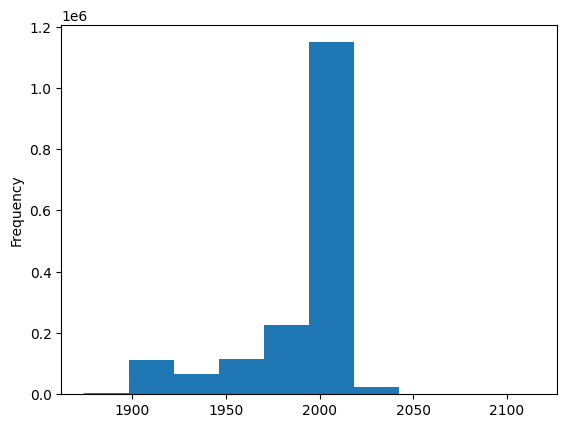

In [15]:
imdb_titles_raw["startYear"].plot.hist()
imdb_titles_raw.query("startYear > 2019")["startYear"].value_counts().sort_index()

Takhle nějak by přetypování mohlo vypadat:

In [16]:
(
    imdb_titles_raw
    .assign(
        titleType=imdb_titles_raw["titleType"].astype("category"),
        startYear=imdb_titles_raw["startYear"].astype("Int64"),
        endYear=imdb_titles_raw["endYear"].astype("Int64"),
        isAdult=imdb_titles_raw["isAdult"].astype(bool),
        runtimeMinutes=imdb_titles_raw["runtimeMinutes"].astype("Int64")
    )
).dtypes

tconst              object
titleType         category
primaryTitle        object
originalTitle       object
isAdult               bool
startYear            Int64
endYear              Int64
runtimeMinutes       Int64
genres              object
dtype: object

Takhle už by to mohlo být. Jen si ještě:

- pro přehlednost přejmenujeme některé sloupce (pomocí metody [`rename`](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.rename.html))
- použijeme `tconst` jako index

A tabulka `imdb_titles` bude připravená k použití!

In [17]:
imdb_titles = (
    imdb_titles_raw
    .assign(
        titleType=imdb_titles_raw["titleType"].astype("category"),
        startYear=imdb_titles_raw["startYear"].astype("Int64"),
        endYear=imdb_titles_raw["endYear"].astype("Int64"),
        isAdult=imdb_titles_raw["isAdult"].astype(bool),
        runtimeMinutes=imdb_titles_raw["runtimeMinutes"].astype("Int64")
    )
    .rename({
        "primaryTitle": "title",
        "originalTitle": "original_title",
        "titleType": "title_type",
        "runtimeMinutes": "length",
        "startYear": "start_year",
        "endYear": "end_year",
        "isAdult": "is_adult",
    }, axis="columns")
    .set_index("tconst")
)
imdb_titles

,title_type,title,original_title,is_adult,start_year,end_year,length,genres
tconst,,,,,,,,
tt0000001,short,Carmencita,Carmencita,False,1894,<NA>,1,"Documentary,Short"
tt0000002,short,Le clown et ses chiens,Le clown et ses chiens,False,1892,<NA>,5,"Animation,Short"
tt0000003,short,Pauvre Pierrot,Pauvre Pierrot,False,1892,<NA>,4,"Animation,Comedy,Romance"
tt0000004,short,Un bon bock,Un bon bock,False,1892,<NA>,<NA>,"Animation,Short"
tt0000005,short,Blacksmith Scene,Blacksmith Scene,False,1893,<NA>,1,"Comedy,Short"
...,...,...,...,...,...,...,...,...
tt9916734,video,Manca: Peleo,Manca: Peleo,False,2018,<NA>,<NA>,"Music,Short"
tt9916754,movie,Chico Albuquerque - Revelações,Chico Albuquerque - Revelações,False,2013,<NA>,<NA>,Documentary
tt9916756,short,Pretty Pretty Black Girl,Pretty Pretty Black Girl,False,2019,<NA>,<NA>,Short


In [18]:
# Kolik tabulka zabírá megabajtů paměti?
imdb_titles.memory_usage(deep=True).sum() / 2**20   # O chlup méně, zase tolik jsme si ale nepomohli.

np.float64(481.7380132675171)

Připravíme si ještě speciální tabulku jenom pro filmy, protože další datové sady se zabývají jenom jimi.

U této tabulky navíc vyhodíme zbytečné sloupce `title_type`, `end_year` a přejmenujeme `start_year` prostě na `year`:

In [19]:
movies = (
    imdb_titles
    .query("title_type == 'movie'")
    .drop(["title_type", "end_year"], axis="columns")
    .rename({"start_year": "year"}, axis="columns")
)
movies

,title,original_title,is_adult,year,length,genres
tconst,,,,,,
tt0000009,Miss Jerry,Miss Jerry,False,1894,45,Romance
tt0000147,The Corbett-Fitzsimmons Fight,The Corbett-Fitzsimmons Fight,False,1897,20,"Documentary,News,Sport"
tt0000335,Soldiers of the Cross,Soldiers of the Cross,False,1900,<NA>,"Biography,Drama"
tt0000502,Bohemios,Bohemios,False,1905,100,NaN
tt0000574,The Story of the Kelly Gang,The Story of the Kelly Gang,False,1906,70,"Biography,Crime,Drama"
...,...,...,...,...,...,...
tt9916622,Rodolpho Teóphilo - O Legado de um Pioneiro,Rodolpho Teóphilo - O Legado de um Pioneiro,False,2015,<NA>,Documentary
tt9916680,De la ilusión al desconcierto: cine colombiano...,De la ilusión al desconcierto: cine colombiano...,False,2007,100,Documentary
tt9916706,Dankyavar Danka,Dankyavar Danka,False,2013,<NA>,Comedy


In [20]:
print(movies.shape)
print(movies.dtypes)

(514654, 6)
title             object
original_title    object
is_adult            bool
year               Int64
length             Int64
genres            object
dtype: object


Nyní se podíváme na zoubek hodnocením z IMDb, na tabulky `imdb_ratings_raw`:

In [21]:
imdb_ratings_raw

,tconst,averageRating,numVotes
0,tt0000001,5.8,1486
1,tt0000002,6.4,179
2,tt0000003,6.6,1117
3,tt0000004,6.4,109
4,tt0000005,6.2,1820
...,...,...,...
923691,tt9916380,9.7,58
923692,tt9916420,7.0,5
923693,tt9916460,9.2,12
923694,tt9916720,5.2,11


In [ ]:
imdb_ratings_raw.dtypes

To by vlastně skoro mohlo být!

Tak jen nastavíme index (opět `tconst`) a přejmenujeme sloupce:

In [22]:
ratings = (imdb_ratings_raw
    .rename({
        "averageRating": "imdb_rating",
        "numVotes": "imdb_votes"
    }, axis="columns")
    .set_index("tconst")
)
ratings

,imdb_rating,imdb_votes
tconst,,
tt0000001,5.8,1486
tt0000002,6.4,179
tt0000003,6.6,1117
tt0000004,6.4,109
tt0000005,6.2,1820
...,...,...
tt9916380,9.7,58
tt9916420,7.0,5
tt9916460,9.2,12


#### První join

Máme připravené dvě krásné tabulky, které sdílejí stejný index, a můžeme vesele spojovat. Protože pomocí `join`, `merge` a `concat` lze volbou vhodných parametrů dosáhnout identického výsledku (což je jedním z nešvarů knihovny `pandas`), ukážeme si všechny tři alternativy podle subjektivního pořadí vhodnosti.

In [23]:
movies.join(ratings)

,title,original_title,is_adult,year,length,genres,imdb_rating,imdb_votes
tconst,,,,,,,,
tt0000009,Miss Jerry,Miss Jerry,False,1894,45,Romance,5.5,77.0
tt0000147,The Corbett-Fitzsimmons Fight,The Corbett-Fitzsimmons Fight,False,1897,20,"Documentary,News,Sport",5.2,289.0
tt0000335,Soldiers of the Cross,Soldiers of the Cross,False,1900,<NA>,"Biography,Drama",6.3,39.0
tt0000502,Bohemios,Bohemios,False,1905,100,NaN,NaN,NaN
tt0000574,The Story of the Kelly Gang,The Story of the Kelly Gang,False,1906,70,"Biography,Crime,Drama",6.2,505.0
...,...,...,...,...,...,...,...,...
tt9916622,Rodolpho Teóphilo - O Legado de um Pioneiro,Rodolpho Teóphilo - O Legado de um Pioneiro,False,2015,<NA>,Documentary,NaN,NaN
tt9916680,De la ilusión al desconcierto: cine colombiano...,De la ilusión al desconcierto: cine colombiano...,False,2007,100,Documentary,NaN,NaN
tt9916706,Dankyavar Danka,Dankyavar Danka,False,2013,<NA>,Comedy,NaN,NaN


K tabulce se nenápadně přidaly dva sloupce z tabulky `ratings`, a to takovým způsobem, že se porovnaly hodnoty indexu (tedy `tconst`) a spárovaly se ty části řádku, kde se tento index shoduje.

💡 Uvědom si (ačkoliv z volání funkcí v `pandas` to není úplně zřejmé), že se tady děje něco fundamentálně odlišného od "nalepení doprava" - tabulky tu nejsou chápány jako čtverečky, které jde skládat jako lego, nýbrž jako zdroj údajů o jednotlivých objektech, které je potřeba spojit sémanticky.

Jak ale vidíš, tabulka obsahuje spoustu řádků, kde ve sloupcích s hodnocením chybí hodnoty (respektive nachází se `NaN`). To vychází ze způsobu, jakým metoda `join` ve výchozím nastavení "joinuje" - použije všechny řádky z levé tabulky bez ohledu na to, jestli jim odpovídá nějaký protějšek v tabulce pravé. Naštěstí lze pomocí argumentu `how` specifikovat i jiné způsoby spojování:

- `left` (výchozí pro metodu `join`) - vezmou se všechny prvky z levé tabulky a jim odpovídající prvky z pravé tabulky (kde nejsou, doplní se `NaN`)
- `right` - vezmou se všechny prvky z pravé tabulky a jim odpovídající prvky z levé tabulky (kde nejsou, doplní se `NaN`)
- `inner` (výchozí pro funkci `merge`) - vezmou se jen ty prvky, které jsou v levé i pravé tabulce.
- `outer` (výchozí pro funkci `concat`) - vezmou se všechny prvky, z levé i pravé tabulky, kde něco chybí, doplní se `NaN`.

V podobě Vennově diagramu, kde kruhy představují množiny řádků v obou zdrojových tabulkách a modrou barvou jsou zvýrazněny řádky v tabulce cílové:

![Typy joinů](static/joins.svg)

*Obrázek adaptován z https://upload.wikimedia.org/wikipedia/commons/9/9d/SQL_Joins.svg (autor: Arbeck)*

💡 Až budeme probírat databáze, tyto čtyři typu joinů se nám znovu vynoří.

Následující výpis ukáže, kolik řádků bychom dostali při použití různých hodnot `how`:

In [24]:
for how in ["left", "right", "inner", "outer"]:
    print(f"movies.join(ratings, how=\"{how}\"):", movies.join(ratings, how=how).shape[0], "řádků.")

movies.join(ratings, how="left"): 514654 řádků.
movies.join(ratings, how="right"): 923696 řádků.
movies.join(ratings, how="inner"): 232496 řádků.
movies.join(ratings, how="outer"): 1205854 řádků.


A teď tedy ty tři alternativy:

In [25]:
# Alternativa 1 (preferovaná)
movies_with_rating = movies.join(ratings, how="inner")
movies_with_rating

,title,original_title,is_adult,year,length,genres,imdb_rating,imdb_votes
tconst,,,,,,,,
tt0000009,Miss Jerry,Miss Jerry,False,1894,45,Romance,5.5,77
tt0000147,The Corbett-Fitzsimmons Fight,The Corbett-Fitzsimmons Fight,False,1897,20,"Documentary,News,Sport",5.2,289
tt0000335,Soldiers of the Cross,Soldiers of the Cross,False,1900,<NA>,"Biography,Drama",6.3,39
tt0000574,The Story of the Kelly Gang,The Story of the Kelly Gang,False,1906,70,"Biography,Crime,Drama",6.2,505
tt0000615,Robbery Under Arms,Robbery Under Arms,False,1907,<NA>,Drama,4.8,14
...,...,...,...,...,...,...,...,...
tt9910930,Jeg ser deg,Jeg ser deg,False,2019,75,"Crime,Documentary",4.6,5
tt9911774,Padmavyuhathile Abhimanyu,Padmavyuhathile Abhimanyu,False,2019,130,Drama,8.5,363
tt9913056,Swarm Season,Swarm Season,False,2019,86,Documentary,6.2,5


In [26]:
# Alternativa 2 (taky dobrá)
pd.merge(movies, ratings, left_index=True, right_index=True)

,title,original_title,is_adult,year,length,genres,imdb_rating,imdb_votes
tconst,,,,,,,,
tt0000009,Miss Jerry,Miss Jerry,False,1894,45,Romance,5.5,77
tt0000147,The Corbett-Fitzsimmons Fight,The Corbett-Fitzsimmons Fight,False,1897,20,"Documentary,News,Sport",5.2,289
tt0000335,Soldiers of the Cross,Soldiers of the Cross,False,1900,<NA>,"Biography,Drama",6.3,39
tt0000574,The Story of the Kelly Gang,The Story of the Kelly Gang,False,1906,70,"Biography,Crime,Drama",6.2,505
tt0000615,Robbery Under Arms,Robbery Under Arms,False,1907,<NA>,Drama,4.8,14
...,...,...,...,...,...,...,...,...
tt9910930,Jeg ser deg,Jeg ser deg,False,2019,75,"Crime,Documentary",4.6,5
tt9911774,Padmavyuhathile Abhimanyu,Padmavyuhathile Abhimanyu,False,2019,130,Drama,8.5,363
tt9913056,Swarm Season,Swarm Season,False,2019,86,Documentary,6.2,5


In [27]:
# Alternativa 3 (méně "sémantická")
pd.concat([movies, ratings], axis="columns", join="inner")

,title,original_title,is_adult,year,length,genres,imdb_rating,imdb_votes
tconst,,,,,,,,
tt0000009,Miss Jerry,Miss Jerry,False,1894,45,Romance,5.5,77
tt0000147,The Corbett-Fitzsimmons Fight,The Corbett-Fitzsimmons Fight,False,1897,20,"Documentary,News,Sport",5.2,289
tt0000335,Soldiers of the Cross,Soldiers of the Cross,False,1900,<NA>,"Biography,Drama",6.3,39
tt0000574,The Story of the Kelly Gang,The Story of the Kelly Gang,False,1906,70,"Biography,Crime,Drama",6.2,505
tt0000615,Robbery Under Arms,Robbery Under Arms,False,1907,<NA>,Drama,4.8,14
...,...,...,...,...,...,...,...,...
tt9910930,Jeg ser deg,Jeg ser deg,False,2019,75,"Crime,Documentary",4.6,5
tt9911774,Padmavyuhathile Abhimanyu,Padmavyuhathile Abhimanyu,False,2019,130,Drama,8.5,363
tt9913056,Swarm Season,Swarm Season,False,2019,86,Documentary,6.2,5


Zkusme si zreprodukovat pořadí 250 nejlepších filmů z IMDb (viz https://www.imdb.com/chart/top/?ref_=nv_mv_250):

In [28]:
# Ty nejlepší (do června 2019)
(movies_with_rating
    .query("imdb_votes > 25000")                  # Berou se jen filmy s více než 25000 hlasy
    .sort_values("imdb_rating", ascending=False)  # IMDb tu použivá i váhu jednotlivých hlasů (kterou neznáme)
    .reset_index(drop=True)
).iloc[:250]

,title,original_title,is_adult,year,length,genres,imdb_rating,imdb_votes
0,The Chaos Class,Hababam Sinifi,False,1975,87,"Comedy,Drama",9.4,33394
1,The Mountain II,Dag II,False,2016,135,"Action,Drama,War",9.3,100095
2,The Shawshank Redemption,The Shawshank Redemption,False,1994,142,Drama,9.3,2071759
3,CM101MMXI Fundamentals,CM101MMXI Fundamentals,False,2013,139,"Comedy,Documentary",9.2,41327
4,The Godfather,The Godfather,False,1972,175,"Crime,Drama",9.2,1421495
...,...,...,...,...,...,...,...,...
245,The Battle of Algiers,La battaglia di Algeri,False,1966,121,"Drama,War",8.1,46768
246,Lagaan: Once Upon a Time in India,Lagaan: Once Upon a Time in India,False,2001,224,"Adventure,Drama,Musical",8.1,91932
247,Gandhi,Gandhi,False,1982,191,"Biography,Drama,History",8.1,205795
248,Fitzcarraldo,Fitzcarraldo,False,1982,158,"Adventure,Drama",8.1,27246


Do výčtu se nám dostaly filmy, které hranici hlasů nepřekračují o moc. Máme důvodné podezření, že toto kritérium dávno změnili. S požadovanými 250 000 hlasy se už blížíme:

In [29]:
(movies_with_rating
    .query("imdb_votes > 250000")
    .sort_values("imdb_rating", ascending=False)
    .reset_index(drop=True)
).iloc[:250]

,title,original_title,is_adult,year,length,genres,imdb_rating,imdb_votes
0,The Shawshank Redemption,The Shawshank Redemption,False,1994,142,Drama,9.3,2071759
1,The Godfather,The Godfather,False,1972,175,"Crime,Drama",9.2,1421495
2,The Dark Knight,The Dark Knight,False,2008,152,"Action,Crime,Drama",9.0,2037678
3,The Godfather: Part II,The Godfather: Part II,False,1974,202,"Crime,Drama",9.0,986451
4,12 Angry Men,12 Angry Men,False,1957,96,Drama,8.9,585132
...,...,...,...,...,...,...,...,...
245,Crash,Crash,False,2004,112,"Crime,Drama,Thriller",7.8,399015
246,The Bourne Supremacy,The Bourne Supremacy,False,2004,108,"Action,Mystery,Thriller",7.8,404789
247,Tangled,Tangled,False,2010,100,"Adventure,Animation,Comedy",7.8,362329
248,Captain Phillips,Captain Phillips,False,2013,134,"Biography,Drama,Thriller",7.8,384378


#### Druhý join

Co tabulka s výdělky (`boxoffice_raw`)?

In [30]:
boxoffice_raw

,rank,title,studio,lifetime_gross,year
0,1,Star Wars: The Force Awakens,BV,936662225,2015
1,2,Avatar,Fox,760507625,2009
2,3,Black Panther,BV,700059566,2018
3,4,Avengers: Infinity War,BV,678815482,2018
4,5,Titanic,Par.,659363944,1997
...,...,...,...,...,...
16262,16263,Dog Eat Dog,IFC,80,2009
16263,16264,Paranoid Girls,NaN,78,2015
16264,16265,Confession of a Child of the Century,Cohen,74,2015
16265,16266,Storage 24,Magn.,72,2013


In [31]:
boxoffice_raw.dtypes

rank               int64
title             object
studio            object
lifetime_gross     int64
year               int64
dtype: object

S tím bychom v podstatně mohli být spokojení, jen přejmenujeme `rank`, abychom při joinování věděli, odkud daný sloupec pochází.

In [33]:
boxoffice = (boxoffice_raw
    .rename({
        "rank": "boxoffice_rank"
    }, axis="columns")
)

A zkusíme joinovat. V tomto případě se nemůžeme opřít o index (`boxoffice` pochází z jiného zdroje a o nějakém ID filmu z IMDb nemá ani tuchy), ale explicitně specifikujeme, který sloupec (či sloupce) se musí shodovat - na to slouží argument `on`:

In [34]:
pd.merge(
    movies_with_rating,
    boxoffice,
    suffixes=[" (imdb)", " (boxoffice)"],
    on="title"
).query("title == 'Pinocchio'")  # "Jeden" ukázkový film

,title,original_title,is_adult,year (imdb),length,genres,imdb_rating,imdb_votes,boxoffice_rank,studio,lifetime_gross,year (boxoffice)
444,Pinocchio,Pinocchio,False,1940,88,"Animation,Comedy,Family",7.5,114689,885,Dis.,84254167,1940
445,Pinocchio,Pinocchio,False,1940,88,"Animation,Comedy,Family",7.5,114689,6108,Mira.,3684305,2002
1105,Pinocchio,Turlis Abenteuer,False,1967,75,"Adventure,Family,Fantasy",7.2,19,885,Dis.,84254167,1940
1106,Pinocchio,Turlis Abenteuer,False,1967,75,"Adventure,Family,Fantasy",7.2,19,6108,Mira.,3684305,2002
1224,Pinocchio,Pinocchio,False,1971,79,"Comedy,Fantasy",3.5,123,885,Dis.,84254167,1940
1225,Pinocchio,Pinocchio,False,1971,79,"Comedy,Fantasy",3.5,123,6108,Mira.,3684305,2002
7219,Pinocchio,Pinocchio,False,1911,50,Fantasy,5.9,69,885,Dis.,84254167,1940
7220,Pinocchio,Pinocchio,False,1911,50,Fantasy,5.9,69,6108,Mira.,3684305,2002
7983,Pinocchio,Pinocchio,False,2002,108,"Comedy,Family,Fantasy",4.3,7192,885,Dis.,84254167,1940
7984,Pinocchio,Pinocchio,False,2002,108,"Comedy,Family,Fantasy",4.3,7192,6108,Mira.,3684305,2002


Jejda, to jsme asi nechtěli. Existuje spousta různých Pinocchiů a ke každému z nich se připojili vždy oba snímky tohoto jména z `boxoffice`. Z toho vyplývá poučení, že při joinování je dobré se zamyslet nad jedinečností hodnot ve sloupci, který používáme jako klíč. Jméno filmu takové očividně není.

V našem konkrétním případě jsme si problému všimli sami, ale pokud bude duplikátní klíč utopen někde v milionech hodnot, rádi bychom, aby to počítač poznal za nás. K tomu slouží argument `validate` - podle toho, jaký vztah mezi tabulkami očekáš, jsou přípustné hodnoty `"one_to_one"`, `"one_to_many"`, `"many_to_one"` nebo `"many_to_many"`:

In [35]:
pd.merge(
    movies_with_rating,
    boxoffice,
    on="title",
    suffixes=[" (imdb)", " (boxoffice)"],
#    validate="one_to_one"    # Odkomentuj a vyskočí chyba!
)

,title,original_title,is_adult,year (imdb),length,genres,imdb_rating,imdb_votes,boxoffice_rank,studio,lifetime_gross,year (boxoffice)
0,Oliver Twist,Oliver Twist,False,1912,<NA>,Drama,4.7,19,6826,Sony,2080321,2005
1,Oliver Twist,Oliver Twist,False,1912,<NA>,Drama,4.4,12,6826,Sony,2080321,2005
2,The Count of Monte Cristo,The Count of Monte Cristo,False,1913,69,"Drama,History",5.4,35,1539,BV,54234062,2002
3,Robin Hood,Robin Hood,False,1913,<NA>,Adventure,5.7,29,652,Uni.,105269730,2010
4,Victory,Victory,False,1913,<NA>,War,5.8,8,4576,Par.,10853418,1981
...,...,...,...,...,...,...,...,...,...,...,...,...
20562,Chaos,Chaos,False,2019,126,Drama,9.1,20,14682,Din.,10289,2005
20563,The Hard Way,The Hard Way,False,2019,92,Action,4.7,893,2945,Uni.,25895485,1991
20564,Gold,Tala,False,2019,<NA>,Drama,5.2,18,5173,Wein.,7227038,2017
20565,Avant qu'on explose,Avant qu'on explose,False,2019,108,Comedy,6.9,41,10995,EOne,116576,2019


Řešení je jednoduché - budeme joinovat přes dva různé sloupce (argument `on` to unese ;-)). Při té příležitosti navíc zjišťujeme, že nedává smysl spojovat filmy, které rok vůbec uvedený nemají, a proto je vyhodíme:

In [36]:
(
    pd.merge(
        movies_with_rating.dropna(subset=["year"]),  # Vyhoď všechny řádky bez roku
        boxoffice,
        on=["title", "year"],
        validate="many_to_one",      # movies_with_rating pořád nejsou unikátní!
    )
).query("title == 'Playback'")

,title,original_title,is_adult,year,length,genres,imdb_rating,imdb_votes,boxoffice_rank,studio,lifetime_gross
6913,Playback,Playback,False,2012,98,"Horror,Thriller",4.3,4478,16256,Magn.,264
7530,Playback,Playback,False,2012,113,Drama,4.9,27,16256,Magn.,264
7712,Playback,Dur d'être Dieu,False,2012,66,Documentary,5.2,8,16256,Magn.,264


Pořád nejsou unikátní! Co s tím?

**Hypotéza:** Vstupujeme na nebezpečnou půdu a zkusíme spekulovat, že informace o ziscích budeme mít nejspíš jen o nejpopulárnějších filmech. Možná máme pravdu, možná ne a nejspíš nějakou drobnou nepřesnost zaneseme, ale dobrat se tady skutečné pravdy je "drahé" (a možná i skutečně drahé), z nabízených datových sad to věrohodně možné není.

Abychom se co nejvíc přiblížili realitě, z každé opakující se dvojice (název, rok) vybereme film s nejvyšším `imdb_votes`. Nejdříve si pomocí `sort_values` srovnáme všechny filmy a pak zavoláme `drop_duplicates(..., keep="first")`, což nám ponechá vždy jen jeden z řady duplikátů:

In [37]:
movies_with_rating_and_boxoffice = (
    pd.merge(
        movies_with_rating
            .dropna(subset=["year"])
            .sort_values("imdb_votes", ascending=False)
            .drop_duplicates(
                subset=["title", "year"],
                keep="first"
            ),
        boxoffice,
        on=["title", "year"],
        validate="one_to_one",
    )
)
movies_with_rating_and_boxoffice

,title,original_title,is_adult,year,length,genres,imdb_rating,imdb_votes,boxoffice_rank,studio,lifetime_gross
0,The Shawshank Redemption,The Shawshank Redemption,False,1994,142,Drama,9.3,2071759,2792,Col.,28341469
1,The Dark Knight,The Dark Knight,False,2008,152,"Action,Crime,Drama",9.0,2037678,10,WB,535234033
2,Inception,Inception,False,2010,148,"Action,Adventure,Sci-Fi",8.8,1816360,85,WB,292576195
3,Fight Club,Fight Club,False,1999,139,Drama,8.8,1657857,2248,Fox,37030102
4,Pulp Fiction,Pulp Fiction,False,1994,154,"Crime,Drama",8.9,1620135,629,Mira.,107928762
...,...,...,...,...,...,...,...,...,...,...,...
8996,The Bride & The Grooms,The Bride & The Grooms,False,2009,99,"Comedy,Romance",7.0,7,15258,Smb.,5995
8997,Sacred,Sacred,False,2017,<NA>,"Action,Drama,Romance",8.2,6,13950,Argo.,17740
8998,The Professor: Tai Chi's Journey West,The Professor: Tai Chi's Journey West,False,2016,72,Documentary,7.2,6,15820,FRun,2852
8999,"Still, the Children Are Here","Still, the Children Are Here",False,2004,85,Documentary,6.6,5,15653,Icar.,3685


In [38]:
# To už by šlo!
movies_with_rating_and_boxoffice.query("title == 'Playback'")

,title,original_title,is_adult,year,length,genres,imdb_rating,imdb_votes,boxoffice_rank,studio,lifetime_gross
5831,Playback,Playback,False,2012,98,"Horror,Thriller",4.3,4478,16256,Magn.,264


**Úkol:** Seřaď filmy podle toho, kolik vydělaly (nabízí se hned dvě možnosti).

In [41]:
movies_with_rating_and_boxoffice.sort_values("lifetime_gross", ascending=False)

,title,original_title,is_adult,year,length,genres,imdb_rating,imdb_votes,boxoffice_rank,studio,lifetime_gross
22,Avatar,Avatar,False,2009,162,"Action,Adventure,Fantasy",7.8,1034207,2,Fox,760507625
153,Black Panther,Black Panther,False,2018,134,"Action,Adventure,Sci-Fi",7.3,489977,3,BV,700059566
90,Avengers: Infinity War,Avengers: Infinity War,False,2018,149,"Action,Adventure,Sci-Fi",8.5,616050,4,BV,678815482
28,Titanic,Titanic,False,1997,194,"Drama,Romance",7.8,945889,5,Par.,659363944
133,Jurassic World,Jurassic World,False,2015,124,"Action,Adventure,Sci-Fi",7.0,533708,6,Uni.,652270625
...,...,...,...,...,...,...,...,...,...,...,...
5602,Trojan War,Trojan War,False,1997,84,Comedy,5.7,5285,16253,WB,309
8562,Intervention,Intervention,False,2007,93,Drama,5.0,173,16255,All.,279
5831,Playback,Playback,False,2012,98,"Horror,Thriller",4.3,4478,16256,Magn.,264
5621,Satanic,Satanic,False,2016,85,Horror,3.7,5211,16257,Magn.,252


**Otázka:** Které filmy nám vypadly a proč?

#### Třetí join

In [42]:
rotten_tomatoes_raw

,Rank,Title,RatingTomatometer,No. of Reviews,Genres
0,1,Black Panther (2018),97,444,action|adventure
1,2,Mad Max: Fury Road (2015),97,394,action|adventure
2,3,Wonder Woman (2017),93,410,action|adventure
3,4,Metropolis (1927),99,118,action|adventure
4,5,Coco (2017),97,308,action|adventure
...,...,...,...,...,...
1585,70,Priest (2011),15,97,western
1586,71,American Outlaws (2001),14,103,western
1587,72,September Dawn (2007),15,54,western
1588,73,Jonah Hex (2010),12,147,western


In [43]:
rotten_tomatoes_raw["Title"].value_counts()

Title
Yellow Submarine (1968)                                 6
Harry Potter and the Deathly Hallows - Part 2 (2011)    5
Beauty and the Beast (1991)                             5
Afghan Star (2009)                                      5
Metropolis (1927)                                       5
                                                       ..
Jane Got a Gun (2016)                                   1
Forsaken (2016)                                         1
Cowboys & Aliens (2011)                                 1
Down in the Valley (2006)                               1
Ned Kelly (2003)                                        1
Name: count, Length: 947, dtype: int64

A zase duplicity, některé názvy se nám opakují :-(

**Otázka:** Dokážeš zjistit proč? Nápověda: podívej se na nějaký konkrétní film.

Naštěstí už víme, jak na to - použijeme metodu `drop_duplicates`, tentokrát přes sloupec `"Title"`. (Poznámka: druhou možností by bylo sloučit všechny různé žánry daného filmu do jedné buňky).

In [44]:
rotten_tomatoes_nodup = (
    rotten_tomatoes_raw
    .drop_duplicates(
        subset="Title",
        keep="first"                   # Vybereme první výskyt, lze i "last" (anebo False => vyhodit všechny)
    )
    .drop("Genres", axis="columns")    # Informační hodnotu jsme už ztratili
    .drop("Rank", axis="columns")      # Mělo smysl jen v rámci žánru
)
rotten_tomatoes_nodup

,Title,RatingTomatometer,No. of Reviews
0,Black Panther (2018),97,444
1,Mad Max: Fury Road (2015),97,394
2,Wonder Woman (2017),93,410
3,Metropolis (1927),99,118
4,Coco (2017),97,308
...,...,...,...
1585,Priest (2011),15,97
1586,American Outlaws (2001),14,103
1587,September Dawn (2007),15,54
1588,Jonah Hex (2010),12,147


In [45]:
# Ready to merge?
pd.merge(imdb_titles, rotten_tomatoes_nodup, left_on="title", right_on="Title")

,title_type,title,original_title,is_adult,start_year,end_year,length,genres,Title,RatingTomatometer,No. of Reviews


0 řádků!

Dosud jsme manipulovali s řádky a sloupci jako celky, nicméně teď musíme zasahovat přímo do hodnot v buňkách. I to se při slučování dat z různých zdrojů nezřídka stává. Stojíme před úkolem převést řetězce typu "Black Panther (2018)" na dvě hodnoty: název "Black Panther" a rok 2018 (jeden sloupec na dva). 

Naštěstí si ty sloupce umíme jednoduše vyrobit pomocí řetězcové metody [`.str.slice`](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.Series.str.slice.html), která z každého řetězce vyřízne nějakou jeho část (a zase pracuje na celém sloupci - výsledkem bude nový sloupec s funkcí aplikovanou na každou z hodnot). Budeme věřit, že předposlední čtyři znaky představují rok a zbytek, až na nějaké ty závorky, tvoří skutečný název:

In [46]:
rotten_tomatoes_beta = (rotten_tomatoes_nodup
    .assign(
        title=rotten_tomatoes_nodup["Title"].str.slice(0, -7),             
        year=rotten_tomatoes_nodup["Title"].str.slice(-5, -1).astype(int)
    )
    .rename({
        "RatingTomatometer": "tomatoes_rating",
        "No. of Reviews": "tomatoes_votes",
    }, axis="columns")
    .drop(["Title"], axis="columns")
)
rotten_tomatoes_beta

,tomatoes_rating,tomatoes_votes,title,year
0,97,444,Black Panther,2018
1,97,394,Mad Max: Fury Road,2015
2,93,410,Wonder Woman,2017
3,99,118,Metropolis,1927
4,97,308,Coco,2017
...,...,...,...,...
1585,15,97,Priest,2011
1586,14,103,American Outlaws,2001
1587,15,54,September Dawn,2007
1588,12,147,Jonah Hex,2010


Závorková odysea nekončí, někdo nám proaktivně do závorek nacpal i originální název naanglickojazyčných filmů. Pojďme se o tom přesvědčit pomocí metody [`.str.contains`](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.Series.str.contains.html) (protože tato metoda ve výchozím stavu používá pro vyhledávání regulární výrazy, které jsme se zatím nenaučili používat, musíme jí to explicitně zakázat argumentem `regex=False`):

In [47]:
rotten_tomatoes_beta[rotten_tomatoes_beta["title"].str.contains(")", regex=False)]

,tomatoes_rating,tomatoes_votes,title,year
15,100,58,Seven Samurai (Shichinin no Samurai),1956
51,98,46,"Aguirre, the Wrath of God (Aguirre, der Zorn G...",1972
61,97,71,Ghostbusters (1984 Original),1984
69,98,47,A Fistful of Dollars (Per un Pugno di Dollari),1964
99,96,139,Embrace Of The Serpent (El Abrazo De La Serpie...,2016
...,...,...,...,...
1368,97,59,To Be and to Have (Etre et Avoir),2003
1457,43,82,Goal! The Dream Begins (Goal!: The Impossible ...,2005
1502,71,52,Only Human (Seres queridos),2006
1547,83,64,"The Good, the Bad, the Weird (Joheun-nom, Nabb...",2010


V rámci zjednodušení proto ještě odstraníme všechny takové závorky. K tomu pomůže funkce [`.str.rsplit`](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.Series.str.rsplit.html), která rozdělí zprava řetězec na několik částí podle oddělovače a vloží je do seznamu - my za ten oddělovač zvolíme levou závorku `"("`, omezíme počet částí na jednu až dvě (`n=1`):

In [48]:
split_title = (
    rotten_tomatoes_beta["title"]
    .str.rsplit("(", n=1)
)
split_title.loc[[41, 61, 81]]   # Některé seznamy obsahují jeden prvek, jiné dva

41            [Marvel's The Avengers]
61    [Ghostbusters , 1984 Original)]
81      [Mad Max 2: The Road Warrior]
Name: title, dtype: object

A jak teď vybrat první prvek z každého seznamu?

💡 Metoda [`apply`](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.Series.apply.html) umožňuje použít libovolnou transformaci (definovanou jako funkci) na každý řádek v tabulce či hodnotu v `Series`. Obvykle se bez ní obejdeme a měli bychom (proto se jí tolik speciálně nevěnujeme), protože není příliš výpočetně efektivní. Tady nám ale usnadní pochopení, co se vlastně dělá, t.j. vybírá první prvek nějakého seznamu:

In [49]:
def take_first(a_list):   # Funkce, kterou použijeme v apply
    return a_list[0]

rotten_tomatoes = (rotten_tomatoes_beta
    .assign(
        title=split_title.apply(take_first)
    )
)
rotten_tomatoes

,tomatoes_rating,tomatoes_votes,title,year
0,97,444,Black Panther,2018
1,97,394,Mad Max: Fury Road,2015
2,93,410,Wonder Woman,2017
3,99,118,Metropolis,1927
4,97,308,Coco,2017
...,...,...,...,...
1585,15,97,Priest,2011
1586,14,103,American Outlaws,2001
1587,15,54,September Dawn,2007
1588,12,147,Jonah Hex,2010


In [50]:
# Zbavení se duplikátů hned na začátku nám zachovalo filmy se stejným jménem :-)
rotten_tomatoes.query("title == 'The Magnificent Seven'")

,tomatoes_rating,tomatoes_votes,title,year
1539,88,42,The Magnificent Seven,1960
1560,63,289,The Magnificent Seven,2016


In [51]:
pd.merge(
    movies.dropna(subset=["year"]),
    rotten_tomatoes,
    on=["title", "year"],
    how="inner"
)

,title,original_title,is_adult,year,length,genres,tomatoes_rating,tomatoes_votes
0,The Birth of a Nation,The Birth of a Nation,False,1915,195,"Drama,History,War",98,40
1,Battleship Potemkin,Bronenosets Potemkin,False,1925,75,"Drama,History",100,45
2,The Gold Rush,The Gold Rush,False,1925,95,"Adventure,Comedy,Drama",100,43
3,Metropolis,Metropolis,False,1927,153,"Drama,Sci-Fi",99,118
4,All Quiet on the Western Front,All Quiet on the Western Front,False,1930,136,"Drama,War",100,42
...,...,...,...,...,...,...,...,...
654,Searching,Searching,False,2018,102,"Drama,Mystery,Thriller",92,214
655,Won't You Be My Neighbor?,Won't You Be My Neighbor?,False,2018,94,"Biography,Documentary",98,216
656,RBG,RBG,False,2018,98,"Biography,Documentary",95,153
657,Hereditary,Hereditary,False,2018,127,"Drama,Horror,Mystery",89,317


Když sloučíme filmy a hodnocení na Rotten Tomatoes, z 947 filmů se nám skoro tři sta ztratí. Bohužel zde je na vině především nestejnost zápisu názvu, různé uřčité členy, interpunkce, podnázvy apod. Coby řešení se tady nabízí spousta a spousta manuální práce, případně nějaká heuristika, která by na sebe pasovala "hodně podobné" názvy.

*Mimochodem, obtížnost manuální práce se mezi vývojáři někdy přeceňuje: Opravit 288 názvů filmů může být práce na hodinu až dvě, zatímco psát algoritmus na "řešení problému" může trvat stejně dlouho, ne-li déle.*

#### Čtvrtý (a poslední) join

Dokončíme slučování všech čtyř tabulek:

In [52]:
movies_complete = pd.merge(
    movies_with_rating_and_boxoffice,
    rotten_tomatoes,
    on=["title", "year"],
    how="inner"
)
movies_complete.sort_values("boxoffice_rank").reset_index(drop=True)

,title,original_title,is_adult,year,length,genres,imdb_rating,imdb_votes,boxoffice_rank,studio,lifetime_gross,tomatoes_rating,tomatoes_votes
0,Black Panther,Black Panther,False,2018,134,"Action,Adventure,Sci-Fi",7.3,489977,3,BV,700059566,97,444
1,Avengers: Infinity War,Avengers: Infinity War,False,2018,149,"Action,Adventure,Sci-Fi",8.5,616050,4,BV,678815482,84,408
2,Titanic,Titanic,False,1997,194,"Drama,Romance",7.8,945889,5,Par.,659363944,89,184
3,Incredibles 2,Incredibles 2,False,2018,118,"Action,Adventure,Animation",7.7,192301,9,BV,608581744,94,332
4,The Dark Knight,The Dark Knight,False,2008,152,"Action,Crime,Drama",9.0,2037678,10,WB,535234033,94,332
...,...,...,...,...,...,...,...,...,...,...,...,...,...
469,Boxing Gym,Boxing Gym,False,2010,91,Documentary,7.1,389,12999,Zipp.,32476,95,42
470,Red Hill,Red Hill,False,2010,95,"Thriller,Western",6.4,7844,13681,Strand,21087,78,65
471,City Lights,City Lights,False,1931,87,"Comedy,Drama,Romance",8.5,144261,13827,UA,19181,98,45
472,Minding the Gap,Minding the Gap,False,2018,93,Documentary,8.1,4119,14471,Magn.,11998,100,63


A přišli jsme o dalších 175 filmů. 

Co dál? Pokud by toto byl skutečný úkol, museli bychom se s tím nějak vypořádat - zkoumat, proč které řádky nesedí, v čem se liší názvy stejného filmu v různých datových sadách, jinými slovy *manuální práce, práce, práce...*

Naštěstí to je úkol jen ukázkový, a my můžeme být spokojeni, že máme sice neúplnou, ale přesto použitelnou datovou sadu :-)